In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
import collections


In [40]:
data = {
    "age": [24,53,23,25,32,52,22,43,52,48],
    "salary": [40000,52000,25000,77000,48000,110000,38000,44000,27000,65000],
    "Degree": [1,0,0,1,1,1,1,0,0,1]
}

In [41]:
df = pd.DataFrame(data)

In [42]:
class TreeNode():
    def __init__(self, attribute_idx=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        # leaf node
        self.value = value 
        # decision node
        self.attribute_idx = attribute_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        


In [43]:
class DTree_model():
    def __init__(self, min_split=2, max_depth=2):
        self.root = None
        self.min_split = min_split
        self.max_depth = max_depth
    # Function to find entropy (Label)
    def entropy_deg(self, y):
        label = np.unique(y)
        entropy_deg = 0
        for i in label:
            #probability
            prob_i = len(y[y == i]) / len(y)
            entropy_deg =entropy_deg+ (-prob_i * np.log2(prob_i))
        return entropy_deg

    #function to find information gain
    def info_gain(self, parent, left_ch, right_ch): 
        left_wt = len(left_ch) / len(parent)
        right_wt = len(right_ch) / len(parent)
        #entropy of attributes
        entropy_att= left_wt*self.entropy_deg(left_ch) + right_wt*self.entropy_deg(right_ch)
        #information gain
        info_gain = self.entropy_deg(parent) - entropy_att
        return info_gain 
        
    def divide(self, df, attribute_idx, threshold):
      # this function is used to create splits in the root node based on the left and right nodes of 
      # threshold values
      df_left = []
      for r in df:
        if r[attribute_idx]<=threshold:
          df_left.append(r)
      df_left = np.array(df_left)
      df_right = []
      for r in df:
        if r[attribute_idx]>threshold:
          df_right.append(r)
      df_right = np.array(df_right)
      return df_left, df_right

    def best_split(self, df, total_sm, attributes):
        # this function is used for getting the best splits among all possible splits 
        # that is used by taking the threshold where information gain is the maximum
        current_split = {}
        maximum_gain = -float("inf")
        # loop through the thresholds of the attributes

        for attribute_idx in range(attributes):
            attribute_values = df[:, attribute_idx]
            thresholds_pred = np.unique(attribute_values)

            for threshold in thresholds_pred:

                df_left, df_right = self.divide(df, attribute_idx, threshold)

                if len(df_left)>0 and len(df_right)>0:
                    y= df[:, -1]
                    left_y= df_left[:, -1]
                    right_y= df_right[:, -1]

                    curr_info_gain = self.info_gain(y, left_y, right_y)

                    if curr_info_gain>maximum_gain:
                        current_split["df_left"] = df_left
                        current_split["df_right"] = df_right
                        current_split["attribute_idx"] = attribute_idx
                        current_split["info_gain"] = curr_info_gain
                        current_split["threshold"] = threshold
                        current_split["df_left"] = df_left
                        current_split["df_right"] = df_right
                        
                        maximum_gain = curr_info_gain
                      
        return current_split
    #Builiding decision tree    
    def build_tree(self, df, curr_depth=0):  
      #this function recursively builds the tree once the root is selected
        X= df[:,:-1]
        y= df[:,-1]
        total_sm= np.shape(X)[0] 
        attributes = np.shape(X)[1]
        if total_sm>=self.min_split and curr_depth<=self.max_depth:
            best_split = self.best_split(df, total_sm, attributes)
            if best_split["info_gain"]>0:
                left_subtree = self.build_tree(best_split["df_left"], curr_depth+1)
                right_subtree = self.build_tree(best_split["df_right"], curr_depth+1)
                return TreeNode(best_split["attribute_idx"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["info_gain"])
        val_leaf = self.calculate_val_leaf(y)
        node= TreeNode(value=val_leaf)
        return node
    
    def calculate_val_leaf(self, Y):
      #this function converts the y variable into a list and then takes the maximum
      #value based on its frequency
        
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def print_tree(self, tree=None, indent=" "):
      #this function is used to recursively print the branches of the tree
        if not tree:
            tree = self.root

        if tree.value is not None:
            val= tree.value
            print(val)

        else:
            print("Attribute: "+str(tree.attribute_idx), "<=", tree.threshold)
            print('Amount of information at this node: {}'.format(f'{tree.info_gain:.3}'))
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        
        df = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(df)
    
    def predict(self, X):
        for i in X:
          predictions= self.do_predict(i, self.root)
        return predictions
    
    def do_predict(self, x, tree):
        #this function recursively calls the predict function to move between the nodes of the
        if tree.value!=None: 
          return tree.value
        attribute_val = x[tree.attribute_idx]
        if attribute_val<=tree.threshold:
            return self.do_predict(x, tree.left)
        else:
            return self.do_predict(x, tree.right)

In [44]:
X_new = df.iloc[:,:-1].values
y_new = df.iloc[:,-1].values.reshape(-1,1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=.2, random_state=41)

In [46]:
model = DTree_model(min_split=3, max_depth=4)
model.fit(X_train,y_train)
model.print_tree()

Attribute: 0 <= 48
Amount of information at this node: 0.311
 left:Attribute: 1 <= 44000
Amount of information at this node: 0.459
  left:Attribute: 0 <= 23
Amount of information at this node: 0.252
    left:0
    right:0
  right:1
 right:0


Univariate Decision Tree:
Advantages:
Univariate: Easy to understand, Faster model.

Multivariate:
Univariate involves only one variable whereas "multivariate" refers to the simultaneous use of several variates or variable quantities. Multivariate decision trees can therefore branch using all qualities at a single node.

Disadvantages:

Univariate: Can overfit easily.

Multivariate:
In multivariate trees, hyperplanes of any orientation are employed. 
This makes the use of search ineffective and unworkable. Therefore, utilizing a linear multivariate node that adds the weights for each feature is a more useful method to use. In order to make the procedure more effective and practical, linear multivariate decision trees select the most crucial features out of all of the available ones.


References:
1. TinaGongting. “Implementing Decision Tree from Scratch in Python.” Medium, Medium, 6 June 2019, https://medium.com/@penggongting/implementing-decision-tree-from-scratch-in-python-c732e7c69aea. 

2. Bujokas, Eligijus. “Decision Tree Algorithm in Python from Scratch.” Medium, Towards Data Science, 14 Apr. 2021, https://towardsdatascience.com/decision-tree-algorithm-in-python-from-scratch-8c43f0e40173.

3. guest_blog. “Decision Tree Implementation in Python from Scratch.” Analytics Vidhya, 22 June 2022, https://www.analyticsvidhya.com/blog/2020/10/all-about-decision-tree-from-scratch-with-python-implementation/. 

4. Valkov, Venelin. “Building a Decision Tree from Scratch in Python.” Medium, Level Up Coding, 5 July 2019, https://levelup.gitconnected.com/building-a-decision-tree-from-scratch-in-python-machine-learning-from-scratch-part-ii-6e2e56265b19. 

# Question 2

### Loading the required libraries

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt 
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score


## Adaboost

In [5]:
class AdaBoost:
        
    def __init__(self):
        self.alphas = [] #for storing the weights for the weak classifiers
        self.combined_classifier = [] #weak classifiers
        self.total = None #number of weak classifiers
        self.errors_l = [] #training error for each of the weak classifier
        self.errors_p = [] #prediction error for each of the weak classifier


    def train(self, X, y, total = 120, use_stumps= False):
    
        self.alphas = [] 
        self.errors_l = []
        self.total = total
        self.errors_p = []

    #for training the weak classifiers
        for m in range(0, total):
            
            if m == 0:
                weights = np.ones(len(y)) / len(y) 
            else:
                #Updating the weights
                weights = self.update_weights(weights, alpha_m, y, y_predicted)

            #First, create a weak classifier
            if use_stumps:
                weak_classifier = DecisionTreeClassifier(max_depth = 1)
            else:
                weak_classifier = DecisionTreeClassifier(max_depth = 5)   
            #Fit classifier with current weights
            weak_classifier.fit(X, y, sample_weight = weights)

            #Predicting labels for training set
            y_predicted = weak_classifier.predict(X)

            #Simply append the weak classifier
            self.combined_classifier.append(weak_classifier)
            #Calculating error rate
            error_m = self.compute_error(y, y_predicted, weights)
            self.errors_l.append(error_m)
            #Calculate the weight for the current classifier
            alpha_m = self.compute_alpha(error_m)
            self.alphas.append(alpha_m)

            if m % 100 == 0:
                print(f"error: {error_m}")
        assert len(self.combined_classifier) == len(self.alphas)

    def compute_error(self, y, y_predicted, weights):
        ms = y_predicted != y
        #Calculating the error rate
        return np.dot(weights, ms) / np.sum(weights)

    #for calculating the weight for the current classifier
    def compute_alpha(self, error):
        return 0.5 * np.log( (1 - error) / error)


    def predict(self, X):
        #Storing the predictions from the weak classifiers
        weak_preds = np.zeros(shape = (len(X), self.total))

        #Predict the labels for the test set
        for m in range(self.total):
            y_predicted = self.combined_classifier[m].predict(X)
            #Weight the predictions by the weight of the weak classifier
            y_predicted = y_predicted * self.alphas[m]
            weak_preds[:,m] = y_predicted
        #Combining the predictions from the weak classifiers using the sign function
        y_predicted = np.sign(np.sum(weak_preds, axis = 1))
        return y_predicted

    
    def err_rate_m(self, X, y):
        #To store the error rates for each iteration
        err_rate_m = np.zeros(shape = (self.total,))

        #Calculatin the error rate for each iteration
        for m in range(self.total):
            y_predicted = self.combined_classifier[m].predict(X)
            error_m = compute_error(y, y_predicted, weights = np.ones(len(y)))
            err_rate_m[m] = error_m
        self.errors_p = err_rate_m
        return err_rate_m
    def update_weights(self, weights, alpha, y, y_h):
        # Compute the indicator function for the misclassified points
        ms = y != y_h
        #Updating the weights
        weights = weights * np.exp(alpha * ms)
        return weights




### Adaboost with max_depth = 1 (using stumps - shallow trees)

#### Letter - Recognition Dataset

In [6]:
data_col = ['letter','x-box','y-box','width','high','onpix','x-bar','y-bar','x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']
dataframe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data', sep=',', header=None, names=data_col,skiprows=None, na_values='?', keep_default_na=False, engine='python')
dataframe.columns = data_col
df = dataframe[(dataframe['letter']=='C') | (dataframe['letter']=='G')]
df.letter.replace(to_replace=dict(C=1, G=2), inplace=True)


X1_train, X1_test, y1_train, y1_test = train_test_split(df.drop(columns = 'letter').values, df['letter'].values,  train_size = 400, random_state = 2) 


ada_ob1 = AdaBoost()
ada_ob1.train(X1_train, y1_train, total = 350, use_stumps = True)
y1_pred = ada_ob1.predict(X1_test)



error: 0.22500000000000003
error: 0.47189502655045734
error: 0.47839780463815845
error: 0.48730157001141844


/var/folders/t2/9dpgbdtx0576q0_kf2wfzl500000gn/T/ipykernel_15148/1499435118.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.letter.replace(to_replace=dict(C=1, G=2), inplace=True)


In [8]:
print('Error:', ada_ob1.compute_error(y1_test, y1_pred, np.ones(len(y1_test))))

Error: 0.5229936880072137


In [9]:
accuracy_score(y1_test, y1_pred)

0.4770063119927863

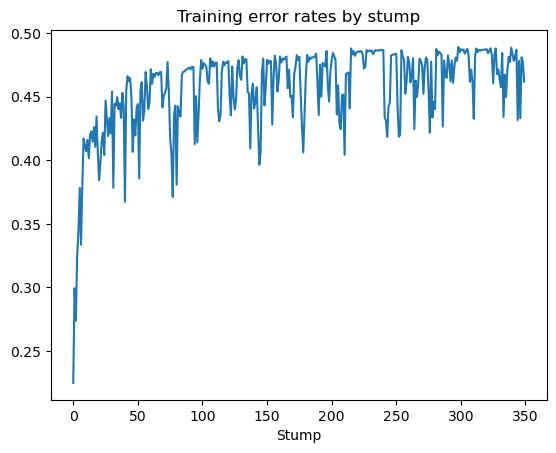

In [10]:
plt.figure()
plt.plot(ada_ob1.errors_l)
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

### Adaboost with max_depth = 9 (without stumps - deep trees)

In [11]:
data_col = ['letter','x-box','y-box','width','high','onpix','x-bar','y-bar',
            'x2bar','y2bar','xybar','x2ybr','xy2br','x-ege','xegvy','y-ege','yegvx']
X = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data', sep=',', header=None, names=data_col,skiprows=None, na_values='?', keep_default_na=False, engine='python')
X.columns = data_col

df = X[(X['letter']=='C') | (X['letter']=='G')]
df.letter.replace(to_replace=dict(C=1, G=2), inplace=True)
df.head()

X2_train, X2_test, y2_train, y2_test = train_test_split(df.drop(columns = 'letter').values, df['letter'].values,  train_size = 450,random_state = 3) 


ada_obj2 = AdaBoost()

ada_obj2.train(X2_train, y2_train, total = 450, use_stumps = False)

y2_pred = ada_obj2.predict(X2_test)

print("error:",(ada_obj2.compute_error(y2_test, y2_pred, np.ones(len(y2_test)))))



/var/folders/t2/9dpgbdtx0576q0_kf2wfzl500000gn/T/ipykernel_15148/3534618446.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.letter.replace(to_replace=dict(C=1, G=2), inplace=True)


error: 0.04444444444444444
error: 0.1456421688905962
error: 0.04153100592852879
error: 0.14531202638034946
error: 0.10159537493810862
error: 0.5070821529745042


### Accuracy


In [12]:
accuracy_score(y2_test, y2_pred)

0.49291784702549574

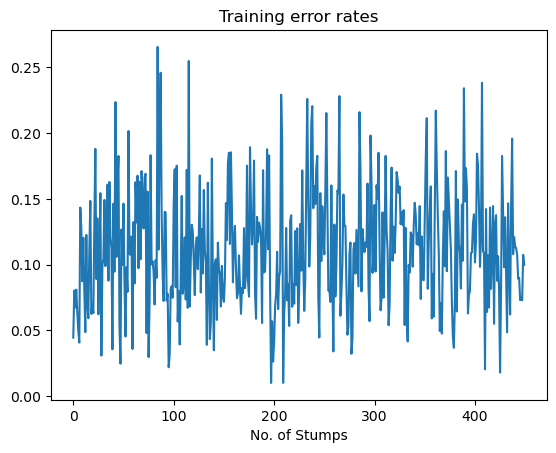

In [13]:
plt.figure()
plt.plot(ada_obj2.errors_l)
plt.title('Training error rates')
plt.xlabel('No. of Stumps')
plt.show()

### Adaboost on German dataset with max_depth = 1 (with stumps - shallow trees)


In [14]:
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
dataframe = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
, delimiter=' ', skiprows=0, names = names)
dataframe.classification.replace([1,2], [1,0], inplace=True)
num_ix = dataframe.select_dtypes(include=['int64', 'float64']).columns
subset = dataframe[num_ix]


X3_train, X3_test, y3_train, y3_test = train_test_split(subset.drop(columns = 'classification').values, subset['classification'].values,train_size = 350, random_state = 2) 
ada_obj3 = AdaBoost()
ada_obj3.train(X3_train, y3_train, total = 400, use_stumps = True)
ada_obj3
y3_pred = ada_obj3.predict(X3_test)

print('error:', (ada_obj3.compute_error(y3_test, y3_pred, np.ones(len(y3_test)))))

error: 0.2800000000000001
error: 0.4867113565753959
error: 0.4965274564544986
error: 0.49685577411181153
error: 0.3030769230769231


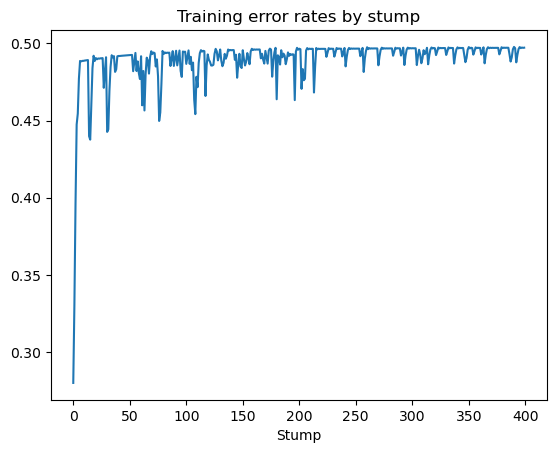

In [15]:
plt.figure()
plt.plot(ada_obj3.errors_l)
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

### Adaboost on German Dataset with max_depth = 9 (without stumps - deep trees)


In [17]:
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
, delimiter=' ', skiprows=0, names = names)

data.classification.replace([1,2], [1,0], inplace=True)

num_ix = data.select_dtypes(include=['int64', 'float64']).columns
subset = data[num_ix]

X4_train, X4_test, y4_train, y4_test = train_test_split(subset.drop(columns = 'classification').values, subset['classification'].values, train_size = 400, random_state = 2) 

ab4 = AdaBoost()
ab4.train(X4_train, y4_train, total = 400, use_stumps = False)

y4_pred = ab4.predict(X4_test)

print('Error:', ab4.compute_error(y4_test, y4_pred, np.ones(len(y4_test))))

error: 0.19750000000000004
error: 0.4733511195839507
error: 0.4029301222120669
error: 0.40845887602134956
Error: 0.3016666666666667


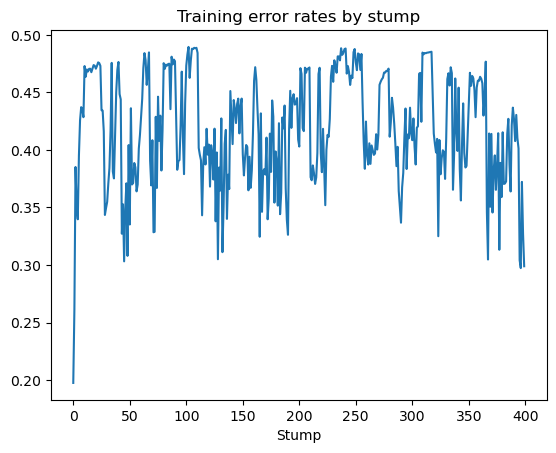

In [18]:
plt.figure()
plt.plot(ab4.errors_l)
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

### Adaboost on Spambase Dataset with max_depth = 1 (with stumps - shallow trees)


In [19]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header = None)
names = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names', sep = ':', skiprows=range(0, 33), header = None)
col_names = list(names[0])
col_names.append('Spam')
df.columns = col_names
df['Spam'] = df['Spam'] * 2 - 1
X5_train, X5_test, y5_train, y5_test = train_test_split(df.drop(columns = 'Spam').values, df['Spam'].values, train_size = 3065, random_state = 2) 
ab5 = AdaBoost()
ab5.train(X5_train, y5_train, total = 400, use_stumps = True)
y5_pred = ab5.predict(X5_test)
print('Error rate:', ab5.compute_error(y5_test, y5_pred, np.ones(len(y5_test))))

error: 0.20032626427406225
error: 0.4849899714504628
error: 0.49108807835534585
error: 0.49095342419192983
Error rate: 0.059895833333333336


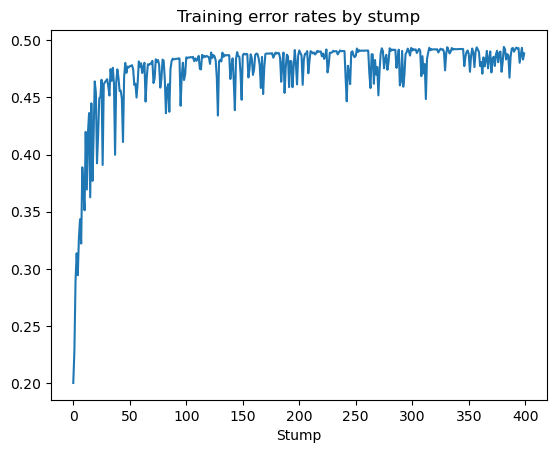

In [20]:
plt.figure()
plt.plot(ab5.errors_l)
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()


### Adaboost on German Dataset with max_depth = 9 (without stumps - deep trees)


In [23]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data', header = None)
names = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.names', sep = ':', skiprows=range(0, 33), header = None)
col_names = list(names[0])
col_names.append('Spam')

df.columns = col_names

df['Spam'] = df['Spam'] * 2 - 1

X6_train, X6_test, y6_train, y6_test = train_test_split(df.drop(columns = 'Spam').values, df['Spam'].values, train_size = 3000, random_state = 3) 

ab6 = AdaBoost()
ab6.train(X6_train, y6_train, total = 450, use_stumps = False)

y6_pred = ab6.predict(X6_test)

print('Error:', ab6.compute_error(y6_test, y6_pred, np.ones(len(y6_test))))

error: 0.07799999999999997
error: 0.332725706511436
error: 0.3662506215376269
error: 0.36024757869924684
error: 0.4163860344614075
Error: 0.04497189256714553


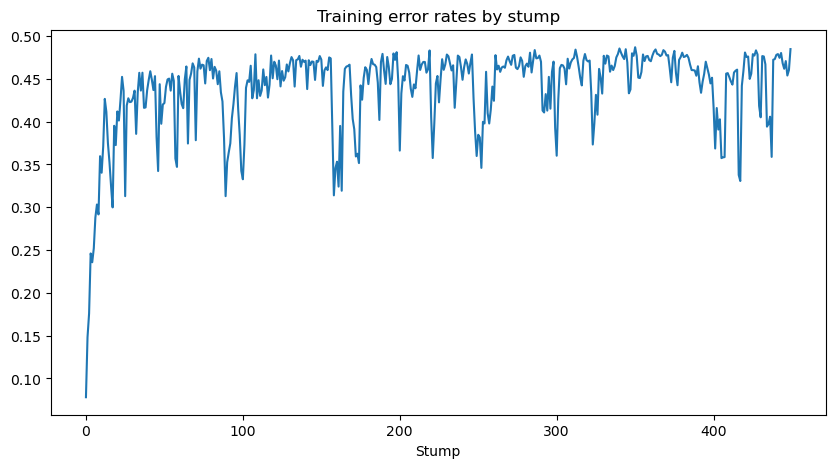

In [24]:
plt.figure(figsize=(10,5))
plt.plot(ab6.errors_l)
plt.title('Training error rates by stump')
plt.xlabel('Stump')
plt.show()

## Importing the necessary libraries


In [25]:
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt 
from sklearn.base import clone
import numpy as np
from sklearn.metrics import accuracy_score,precision_score,recall_score
import pandas as pd
from collections import Counter

## Bagging


In [26]:
class Bagging_classifier(object):
    def __init__(self,total_number_of_nodes=350):
        self.total_number_of_nodes = total_number_of_nodes
        self.classifier_model = []
        self.errors_l = []
    def __del__(self):
        del self.total_number_of_nodes
        del self.classifier_model
        
    def __get_btrps(self,dataset):
        final_output_dict   = {}
        number_of_unique_values = 0
        length_of_data = dataset.shape[0]
        row_pointers = [m for m in range(length_of_data)]
        for q in range(self.total_number_of_nodes):
            next_pointer   = np.random.choice(row_pointers,replace=True,size=length_of_data)
            sample_with_replm = dataset[next_pointer,:]
            number_of_unique_values  += len(set(next_pointer))
            oob_sample_pointer   = list(set(row_pointers) - set(next_pointer))
            oob_sample = np.array([])
            if oob_sample_pointer:
                oob_sample = dataset[oob_sample_pointer,:]
            final_output_dict['boot_'+str(q)] = {'boot':sample_with_replm,'test':oob_sample}
        return(final_output_dict)
    def get_params(self, deep = False):
        return {'total_number_of_nodes':self.total_number_of_nodes}

    def fit(self,X_training,y_train,get_standards=False,decision_stumps_use = False):
        self.errors_l = []
        training_data = np.concatenate((X_training,y_train.reshape(-1,1)),axis=1)
        repeat_bootstrap_samples = self.__get_btrps(training_data)
        standard_accuracy = np.array([])

        if decision_stumps_use == True:
            decisionTreeClassifier_object = DecisionTreeClassifier(max_depth = 1, class_weight='balanced')
        else:
            decisionTreeClassifier_object = DecisionTreeClassifier(max_depth = 9, class_weight='balanced')
        for q in repeat_bootstrap_samples:
            temp_copy_mdl = clone(decisionTreeClassifier_object)
            temp_copy_mdl.fit(repeat_bootstrap_samples[q]['boot'][:,:-1],repeat_bootstrap_samples[q]['boot'][:,-1].reshape(-1, 1))
            self.classifier_model.append(temp_copy_mdl)
            if repeat_bootstrap_samples[q]['test'].size:
                temp_pd_value  = temp_copy_mdl.predict(repeat_bootstrap_samples[q]['test'][:,:-1])
                a_score = accuracy_score(repeat_bootstrap_samples[q]['test'][:,-1],temp_pd_value)
                standard_accuracy = np.concatenate((standard_accuracy,a_score.flatten()))
                self.errors_l.append(a_score)
        if get_standards == True:
            print("Error: ", np.std(standard_accuracy))
            
    def predict(self,X):
        if not self.classifier_model:
            return(None)
        predictions = []
        for m in self.classifier_model:
            temp_pd_value = m.predict(X)
            predictions.append(temp_pd_value.reshape(-1,1))
        ypred = np.round(np.mean(np.concatenate(predictions,axis=1),axis=1)).astype(int)
        return(ypred)

### Bagging using Stumps on Letter Recognition Data

In [27]:
columns_in_dataset = ['letter_capital','x-box-horizontal-horizontal','y-box-horizontal','width_box','height_box','total_pixels','mean_x','mean_y','mean_x_variance','mean_y_variance','mean_x_y_corr','mean_x_x_y','mean_x_y_y','edge_cnt_ltr','xegvy_corr_y','mean_edge_cnt','yegvx_corr_x']
data_in_file = pd.read_csv('letter-recognition.data', sep=',', header=None, names=columns_in_dataset,skiprows=None, na_values='?', keep_default_na=False, engine='python')
data_in_file.columns = columns_in_dataset

dataFrame_built = data_in_file[(data_in_file['letter_capital']=='C') | (data_in_file['letter_capital']=='G')]
dataFrame_built.letter_capital.replace(to_replace=dict(C=1, G=2), inplace=True)
dataFrame_built.head()

X7_train, X7_test, y7_train, y7_test = train_test_split(dataFrame_built.drop(columns = 'letter_capital').values, dataFrame_built['letter_capital'].values,  train_size = 450,random_state = 3) 

bagging_classifier_object7 = Bagging_classifier()

bagging_classifier_object7.fit(X7_train,y7_train,get_standards=True, decision_stumps_use = True)

y7_pred = bagging_classifier_object7.predict(X7_test)
results = cross_validate(bagging_classifier_object7,X7_train,y7_train,cv=StratifiedKFold(10),scoring='accuracy')
print('Average Accuracy: ',np.mean(results['test_score']))

/var/folders/t2/9dpgbdtx0576q0_kf2wfzl500000gn/T/ipykernel_15148/1445095179.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame_built.letter_capital.replace(to_replace=dict(C=1, G=2), inplace=True)


Error:  0.031405861465381275
Average Accuracy:  0.96


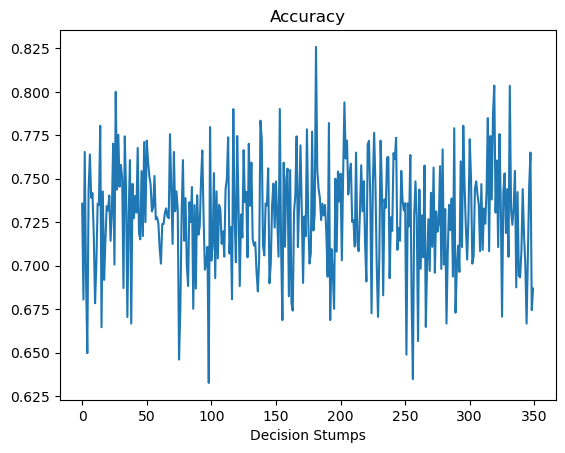

In [28]:
plt.figure()
plt.plot(bagging_classifier_object7.errors_l)
plt.title('Accuracy')
plt.xlabel('Decision Stumps')
plt.show()

### Bagging on letter - recognition data without stumps (Deep trees)

In [29]:
columns_in_dataset = ['letter_capital','x-box-horizontal','y-box-horizontal','width_box','height_box','total_pixels','mean_x','mean_y',
            'mean_x_variance','mean_y_variance','mean_x_y_corr','mean_x_x_y','mean_x_y_y','edge_cnt_ltr','xegvy_corr_y','mean_edge_cnt','yegvx_corr_x']
data_in_file = pd.read_csv('letter-recognition.data', sep=',',lineterminator=None, header=None, names=columns_in_dataset, skiprows=None,on_bad_lines=None, na_values='?',comment=None,  keep_default_na=False, date_parser=None, engine='python')
data_in_file.columns = columns_in_dataset

df = data_in_file[(data_in_file['letter_capital']=='C') | (data_in_file['letter_capital']=='G')]
df.letter_capital.replace(to_replace=dict(C=1, G=2), inplace=True)
df.head()

X8_train, X8_test, y8_train, y8_test = train_test_split(df.drop(columns = 'letter_capital').values, df['letter_capital'].values,  train_size = 450,random_state = 3) 

bagging_classifier_object8 = Bagging_classifier()

bagging_classifier_object8.fit(X8_train,y8_train,get_standards=True, decision_stumps_use = False)

y8_pred = bagging_classifier_object8.predict(X8_test)
results = cross_validate(bagging_classifier_object8,X8_train,y8_train,cv=StratifiedKFold(10),scoring='accuracy')
print('Mean Accuracy: ',np.mean(results['test_score']))

/var/folders/t2/9dpgbdtx0576q0_kf2wfzl500000gn/T/ipykernel_15148/1726703823.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.letter_capital.replace(to_replace=dict(C=1, G=2), inplace=True)


Error:  0.02657293881989972
Mean Accuracy:  0.9622222222222222


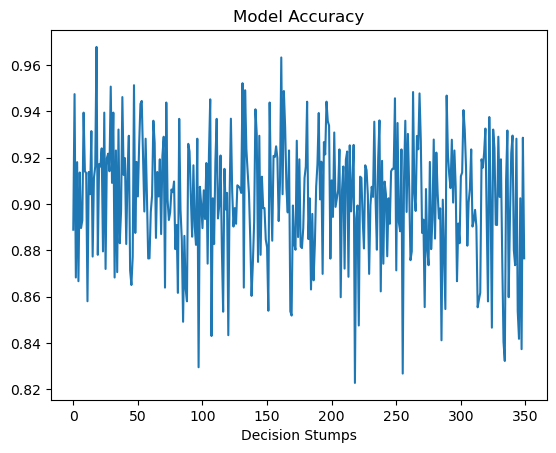

In [30]:
plt.figure()
plt.plot(bagging_classifier_object8.errors_l)
plt.title('Model Accuracy')
plt.xlabel('Decision Stumps')
plt.show()

### Bagging on German Data with stumps(shallow trees)

In [31]:

column_names_dataset = ['ext_chkng', 'span', 'chd_hist', 'moto', 'credit_funds', 'savng', 'emp_since', 'inst_rt', 'ssx', 'othr_dbtr', 'res_since', 'property', 'age', 'othr_plans', 'home', 'existing_credits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
dataset_from_file = pd.read_csv('german.data', lineterminator=None, delimiter=' ', comment=None, skiprows=0,delim_whitespace=False, names = column_names_dataset)
data_numer = dataset_from_file.select_dtypes(include=['int64', 'float64']).columns
data_sub = dataset_from_file[data_numer]

X9_train, X9_test, y9_train, y9_test = train_test_split(data_sub.drop(columns = 'classification').values, data_sub['classification'].values,train_size = 450, random_state = 3) 

bagging_classifier_object9 = Bagging_classifier()
bagging_classifier_object9.fit(X9_train,y9_train,get_standards=True, decision_stumps_use = True)
y9_pred = bagging_classifier_object9.predict(X9_test)
result = cross_validate(bagging_classifier_object9,X9_train,y9_train,cv=StratifiedKFold(10),scoring='accuracy')
print('Mean Accuracy: ', np.mean(result['test_score']))


Error:  0.06442618939748725
Mean Accuracy:  0.6933333333333334


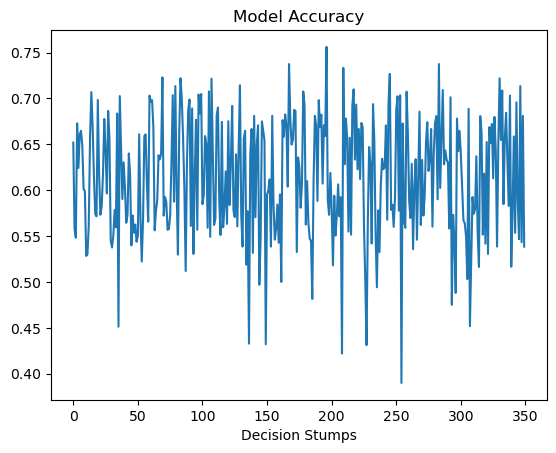

In [32]:
plt.figure()
plt.plot(bagging_classifier_object9.errors_l)
plt.title('Model Accuracy')
plt.xlabel('Decision Stumps')
plt.show()

In [33]:
column_names_dataset = ['ext_chkng', 'span', 'chd_hist', 'moto', 'credit_funds', 'savng', 'emp_since', 'inst_rt', 'ssx', 'othr_dbtr', 'res_since', 'property', 'age', 'othr_plans', 'home', 'existing_credits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
dataset_from_file = pd.read_csv('german.data', dialect=None, delimiter=' ',lineterminator=None, skiprows=0, names = column_names_dataset)

data_numer = dataset_from_file.select_dtypes(include=['int64', 'float64']).columns
data_sub = dataset_from_file[data_numer]

X10_train, X10_test, y10_train, y10_test = train_test_split(data_sub.drop(columns = 'classification').values, data_sub['classification'].values,train_size = 500, random_state = 3) 

bagging_classifier_object10 = Bagging_classifier()
bagging_classifier_object10.fit(X10_train,y10_train,get_standards=True, decision_stumps_use = False)
y10_pred = bagging_classifier_object10.predict(X10_test)
results = cross_validate(bagging_classifier_object10,X10_train,y10_train,cv=StratifiedKFold(10),scoring='accuracy')
print('Mean Accuracy:', np.mean(results['test_score']))


Error:  0.037829359974709466
Mean Accuracy: 0.692


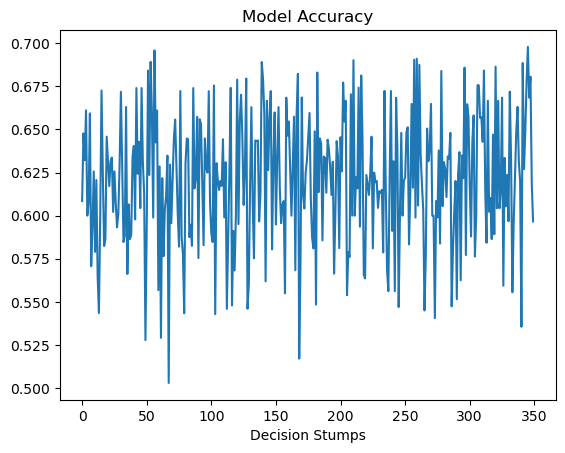

In [34]:
plt.figure()
plt.plot(bagging_classifier_object10.errors_l)
plt.title('Model Accuracy')
plt.xlabel('Decision Stumps')
plt.show()

### Bagging with stumps (max depth = 1 shallow trees) on Spambase data set

In [35]:
dataFrame_built = pd.read_csv('spambase.data', header = None)
column_names = pd.read_csv('spambase.names', sep = ':',lineterminator=None, chunksize=None, escapechar=None, compression='infer',dialect=None,  skiprows=range(0, 33), header = None)
column_names_listed = list(column_names[0])
column_names_listed.append('Spam')

dataFrame_built.columns = column_names_listed
dataFrame_built['Spam'] = dataFrame_built['Spam'] * 2 - 1

X11_train, X11_test, y11_train, y11_test = train_test_split(dataFrame_built.drop(columns = 'Spam').values, dataFrame_built['Spam'].values, train_size = 3000, random_state = 3) 
bagging_classifier_object11 = Bagging_classifier()
bagging_classifier_object11.fit(X11_train,y11_train,get_standards=True, decision_stumps_use = True)
y11_pred = bagging_classifier_object11.predict(X11_test)

results = cross_validate(bagging_classifier_object11,X11_train,y11_train,cv=StratifiedKFold(10),scoring='accuracy')
print('Mean Accuracy: %.2f' % np.mean(results['test_score']))

Error:  0.013293790320585804
Mean Accuracy: 0.88


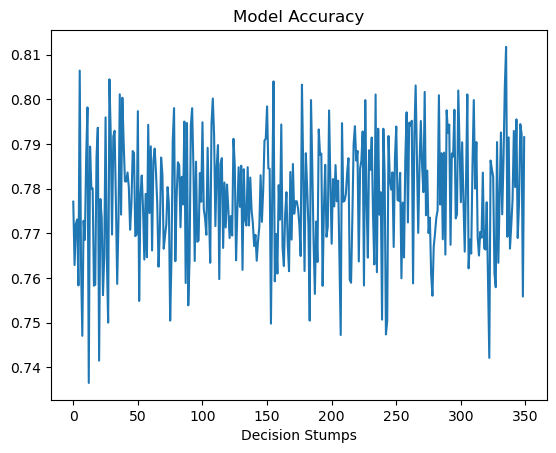

In [36]:
plt.figure()
plt.plot(bagging_classifier_object11.errors_l)
plt.title('Model Accuracy')
plt.xlabel('Decision Stumps')
plt.show()

### Bagging without stumps (max depth= 9 deep trees)

In [37]:
dataFrame_built = pd.read_csv('spambase.data', header = None)
column_names = pd.read_csv('spambase.names', sep = ':', lineterminator=None, skiprows=range(0, 33),doublequote=True, header = None)
column_names_listed = list(column_names[0])
column_names_listed.append('Spam')

dataFrame_built.columns = column_names_listed

dataFrame_built['Spam'] = dataFrame_built['Spam'] * 2 - 1

X12_train, X12_test, y12_train, y12_test = train_test_split(dataFrame_built.drop(columns = 'Spam').values, dataFrame_built['Spam'].values, train_size = 3000, random_state = 3) 
bagging_classifier_object12 = Bagging_classifier()
bagging_classifier_object12.fit(X12_train,y12_train,get_standards=True, decision_stumps_use = False)
y12_pred = bagging_classifier_object12.predict(X12_test)
score = cross_validate(bagging_classifier_object12,X12_train,y12_train,cv=StratifiedKFold(10),scoring='accuracy')
print('Mean Accuracy:',np.mean(score['test_score']))

Error:  0.009152820333196485
Mean Accuracy: 0.8823333333333334


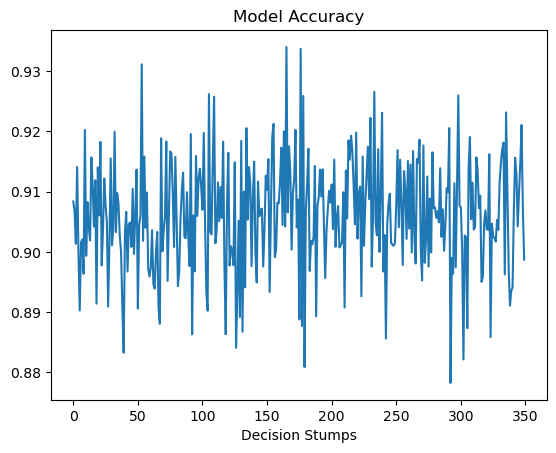

In [38]:
plt.figure()
plt.plot(bagging_classifier_object12.errors_l)
plt.title('Model Accuracy')
plt.xlabel('Decision Stumps')
plt.show()

###### The findings from the above experiments suggest that whenever there is a increase in weak classifier numbers, the error tends to decrease as well but after a certain number it tends to increase (the error). For the adaboost algorithm, a maximum depth of 5 was set for performing experiment on all the three given datasets, and it is observed that the error rate tends to increase after hundred trees. The adaboost algorithm with deep tress also performed well on the spam base dataset.

###### We can also say that AdaBoost is more sensitive to noisy data and outliers, whereas Bagging is less sensitive to outliers and tends to perform well on regression tasks.

References: 

#Adaboost
https://towardsdatascience.com/adaboost-from-scratch-37a936da3d50<br>
#Bagging:
#https://insidelearningmachines.com/build-a-bagging-classifier-in-python/